<a href="https://colab.research.google.com/github/dobrinaVI/Customer-Churn-Prediction-using-XGBOOST/blob/main/Customer_Churn_Prediction_using_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer churn prediction using XGBoost

Using XGBoost to build a collection of boosted trees. Utilizing continuous and categorical customer data from the Telco Churn Dataset (IBM Base Samples) to predict whether or not a customer will stop using the company's survice.

In [5]:
#Install libraries as needed
!pip install pandas-profiling

In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sbn

#from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from imblearn.over_sampling import SMOTE

## 1. Data import and profiling

### 1.1 EDA (Exploratory data analisys)

In [7]:
# Load the data
data = pd.read_csv('https://raw.githubusercontent.com/dobrinaVI/Customer-Churn-Prediction-using-XGBOOST/main/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [8]:
# Generate the Telco Churn Data profiling report
#profile = data.profile_report(title='Telco Churn Profiling Report')
# profile.to_file(output_file="Telco-Churn-Profiling-Report.html")
# profile

The Telco Churn dataset contains 21 variables and 7043 observations with no duplicates or missing cells at first glance. Also, categorical variables seem to contain only the expected values.

Variables summary and closer look:
* customerID - irrelevant for the analisys - *to be dropped*.

Demographics:
* gender (Categorical) - equally distributed
* SeniorCitizen (Categorical) - most customers are not senior citizens (83,8%)
* Partner: Indicates whether the customer has a partner (Yes) or not (No). Equally distributed
* Dependents (Categorical) - olny 30% of the customers are dependants

Subscription-related:
* tenure (Continuous) - defined as Number of months the customer has stayed with the company with mean of 32. Also contains zeros (0.2%), which probably identidy new cusomers.
* PhoneService (Categorical) - defined as Whether the customer has a phone service or not (Yes, No). Most customers (90.3%) have phone service.
* MultipleLines (Categorical) - defined as Whether the customer has multiple lines or not (Yes, No, No phone service). Equally distributed for customers with phone service. In this context "No phone service" has the same meaning as "No".
* InternetService (Categorical) - Customer’s internet service provider (DSL, Fiber optic, No). Mostly Fiber optic (44%)

Options, related to internet service - (Yes, No, No internet service). In this context "No internet service" has the same meaning as "No":
* OnlineSecurity (Categorical) - Mostly No (49%)
* OnlineBackup (Categorical) - Mostly No (43.8%)
* DeviceProtection (Categorical) - Mostly No (43.9%)
* TechSupport (Categorical) - Mostly No (49.3%)
* StreamingTV (Categorical) - Mostly No (39.9%)
* StreamingMovies (Categorical) - Mostly No (39.9%)

Contract-related:
* Contract (Categorical)  - Mostly Month-to-month (55%)
* PaperlessBilling (Categorical) - Mostly paperless (59.2%)
* PaymentMethod - all payments types are used (electronic check, mailed check, bank transfer (automatic), credit card (automatic)), with electronic check splightly more common (33.6%)
* MonthlyCharges (Continuous) - most customers pay ~\$20, with a mean of $65.
* TotalCharges (Categorical) - *should be continuous*
* Churn - 26.5% of customers are lost. *This should be taken into account when training and evaluating the model.*

### 1.2 Features preparation

In [9]:
# Drop unnecessary column customer ID
data.drop('customerID', axis=1, inplace=True)

In [10]:
## Convert TotalCharges to continuous - an error encountered "could not convert
## string to float: ' '", meaning that there are empty values, which need to be fixed
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.nan)
data['TotalCharges'] = data['TotalCharges'].astype(float)
data['TotalCharges'].describe()

,TotalCharges
count,7032.000000
mean,2283.300441
std,2266.771362
min,18.800000
25%,401.450000
50%,1397.475000
75%,3794.737500
max,8684.800000


In [11]:
# Inspect customers with missing charges
data[data['TotalCharges'].isna()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [12]:
len(data[data['TotalCharges'].isna()])

11

All 11 customers with missing charges are actually new customers (tenure=0), therefore it is safe to assume that the charge is not missing, but actually 0 (not charged yet).

In [13]:
# Set TotalCharges to 0, where initially it was empty and make sure it is implemented correctly
data.loc[data['TotalCharges'].isna(),'TotalCharges'] = 0
data.loc[data['TotalCharges']==0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0.0,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0.0,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0.0,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0.0,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0.0,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0.0,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0.0,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0.0,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0.0,No


In [14]:
len(data[data['TotalCharges']==0])

11

In [15]:
# Correct data type for tenure
data['tenure']= data['tenure'].astype(float)

# Correct data type for gender
data['SeniorCitizen']= data['SeniorCitizen'].astype(str)

# Replace the 'No internet/phone service' value with "No"
data[['OnlineSecurity',
      'OnlineBackup',
      'DeviceProtection',
      'TechSupport',
      'StreamingTV',
      'StreamingMovies']]= data[['OnlineSecurity',
                                'OnlineBackup',
                                'DeviceProtection',
                                'TechSupport',
                                'StreamingTV',
                                'StreamingMovies']].replace('No internet service','No')

data[['MultipleLines']]= data[['MultipleLines']].replace('No phone service','No')

In [16]:
## Some of the columns contain blank spaces in the categorical values, so we
## need to fix that to be able to visualise the tree
data.replace(" ","_", regex=True, inplace=True)
data.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1.0,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,Male,0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,0,No,No,45.0,No,No,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,Female,0,No,No,2.0,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes
5,Female,0,No,No,8.0,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,Yes
6,Male,0,No,Yes,22.0,Yes,Yes,Fiber_optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit_card_(automatic),89.10,1949.40,No
7,Female,0,No,No,10.0,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed_check,29.75,301.90,No
8,Female,0,Yes,No,28.0,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,Yes
9,Male,0,No,Yes,62.0,Yes,No,DSL,Yes,Yes,No,No,No,No,One_year,No,Bank_transfer_(automatic),56.15,3487.95,No


## 2. Format the data for XGBoost

### 2.1 Splitting the dataset into features target variable

In [17]:
# Splitting the dataset into features (X) and target variable (y)
X = data.drop('Churn', axis=1)
y = data['Churn']

### 2.2 One-Hot Encoding for categorical variables

In [18]:
X.columns #get a list of the columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [19]:
#One-Hot Encoding for Categorical variables in X
X_encoded = pd.get_dummies(X, columns=['gender', 'SeniorCitizen', 'Partner',
                                       'Dependents', 'PhoneService',
                                       'MultipleLines', 'InternetService',
                                       'OnlineSecurity', 'OnlineBackup',
                                       'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies',
                                       'Contract', 'PaperlessBilling',
                                       'PaymentMethod'])
X_encoded.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,1.0,29.85,29.85,True,False,True,False,False,True,True,...,False,True,False,False,False,True,False,False,True,False
1,34.0,56.95,1889.50,False,True,True,False,True,False,True,...,False,False,True,False,True,False,False,False,False,True
2,2.0,53.85,108.15,False,True,True,False,True,False,True,...,False,True,False,False,False,True,False,False,False,True
3,45.0,42.30,1840.75,False,True,True,False,True,False,True,...,False,False,True,False,True,False,True,False,False,False
4,2.0,70.70,151.65,True,False,True,False,True,False,True,...,False,True,False,False,False,True,False,False,True,False


### 2.3. Label encoding for target variable

In [20]:
# Initialize a LabelEncoder object
encoder = LabelEncoder()

# Fit the encoder on the target variable
encoder.fit(y)

# Transform the target variable using label encoding
y_encoded = encoder.transform(y)

# Print the encoded labels
print(y_encoded[:5])

[0 0 1 0 1]


### 2.4 Feature Selection

In [21]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car,num_but_cat

In [22]:
cat_cols, num_cols, cat_but_car,num_but_cat = grab_col_names(X_encoded)

Observations: 7043
Variables: 39
cat_cols: 36
num_cols: 3
cat_but_car: 0
num_but_cat: 36


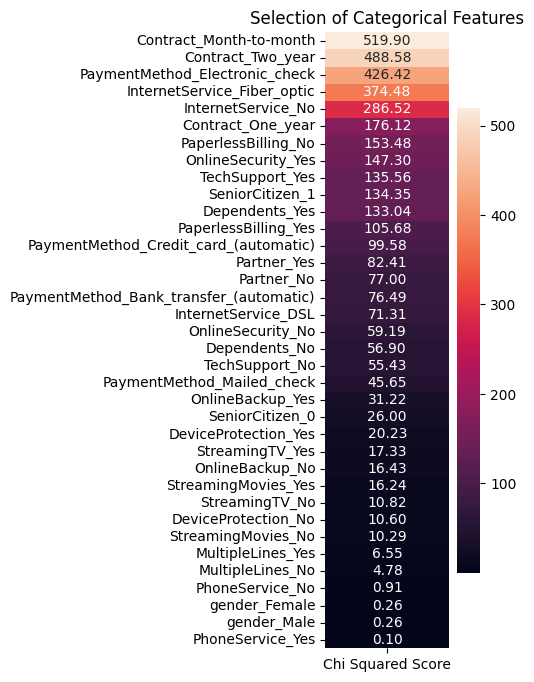

In [23]:
#Scoring and ranking according to the effect of categorical data on the dependent variable
features = X_encoded.loc[:,cat_cols]

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,y_encoded)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score'])

plt.subplots(figsize = (2,8))
sbn.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,fmt = '.2f');
plt.title('Selection of Categorical Features');

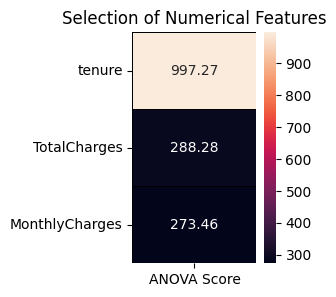

In [24]:
#Scoring and ranking according to the effect of numeric data on the dependent variable
features = X_encoded.loc[:,num_cols]

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,y_encoded)

featureScores_num = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score'])

plt.subplots(figsize = (2,3))
sbn.heatmap(featureScores_num.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

In [25]:
drop_cols_cat = featureScores.sort_values(ascending = False,by = 'Chi Squared Score')[-15:].index

In [26]:
X_encoded.drop(columns =drop_cols_cat,inplace = True)

### 2.5 Split the data into train and testing set
As only 26,5% of the customers left Telco, we need to make sure we maintain the same churn percentage in both the training and testing set.

In [27]:
# Split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded,
                                                    random_state=5, #to endure the split is reproducable
                                                    stratify=y_encoded) #stratifying by Churn

## 3. Build a Preliminary XGBoost Classifier

* The classifier will be trained for binary classification using logistic regression as the objective function.
* Early stopping is also specified, meaning that if the evaluation metric does not improve for 10 consecutive rounds, the training process will be stopped early to prevent overfitting.
* The evaluation metric used will be AUC-PR (area under the precision-recall curve), as it is particularly useful when dealing with imbalanced datasets. AUC-PR captures the trade-off between precision and recall at different classification thresholds. It considers the ability of the classifier to both identify positive instances correctly (high recall) and minimize false positives (high precision).

In [28]:
# Create the Churn XGBoost classifier
churn_clf = xgb.XGBClassifier(objective="binary:logistic", seed=5,
                              early_stopping_rounds=10, eval_metric="aucpr")

# Fit the model as specified
churn_clf.fit(X_train, y_train, verbose=True,
              eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.63083
[1]	validation_0-aucpr:0.64231
[2]	validation_0-aucpr:0.65210
[3]	validation_0-aucpr:0.65350
[4]	validation_0-aucpr:0.65252
[5]	validation_0-aucpr:0.65616
[6]	validation_0-aucpr:0.65758
[7]	validation_0-aucpr:0.65468
[8]	validation_0-aucpr:0.65688
[9]	validation_0-aucpr:0.65754
[10]	validation_0-aucpr:0.65877
[11]	validation_0-aucpr:0.65984
[12]	validation_0-aucpr:0.65850
[13]	validation_0-aucpr:0.65916
[14]	validation_0-aucpr:0.65923
[15]	validation_0-aucpr:0.65951
[16]	validation_0-aucpr:0.65758
[17]	validation_0-aucpr:0.65695
[18]	validation_0-aucpr:0.65647
[19]	validation_0-aucpr:0.65363
[20]	validation_0-aucpr:0.65104


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Evaluate model performance on testing dataset

Running the test data through the model and draw a confusion matrix.

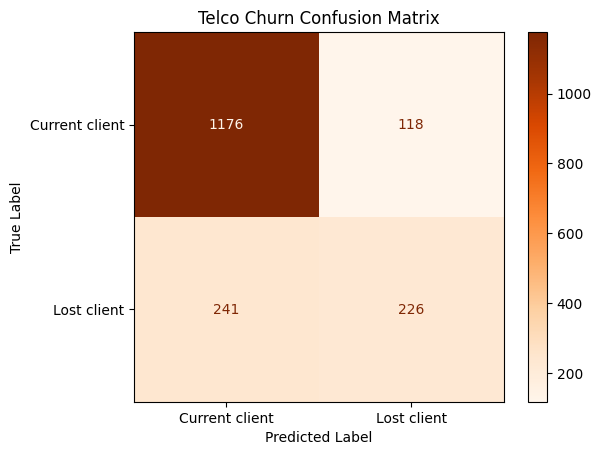

Recall: 0.48394004282655245
Precision: 0.6569767441860465
Specifity: 0.9088098918083463


In [29]:
# Make predictions on the test set
y_pred = churn_clf.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["Current client", "Lost client"])

# Plot the confusion matrix
cm_disp.plot(cmap='Oranges')

# Add title and axis labels
plt.title('Telco Churn Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

#print Recall and Precision:
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Specifity:",cm[0, 0]/(cm[0, 0]+cm[0, 1]))

As seen from the confusion matrix, from the current clients, 91% were classified correctly. From the lost clients, however, only  50% were correctly classified. The observed behaviour is typical for imbalanced datasets.
=> model performance should be optimised.

## 6. Optimise model performance using scale_pos_weight parameter

* scale_pos_weight - XGBoost's own hyperparameter for dealing with imbalanced data. It adds a penalty for incorectly classifying the miority class. XGBoost Manual recommends to set it at sum(negative instances)/sum(positive instances) = non-churned customers/churned customers = 5174/1869 = 2.77

In [30]:
# Create the Churn XGBoost classifier
churn_clf_SPW = xgb.XGBClassifier(objective="binary:logistic", seed=5,
                              early_stopping_rounds=10, eval_metric="aucpr",
                                  scale_pos_weight=2.77)

# Fit the model as specified
churn_clf_SPW.fit(X_train, y_train, verbose=True,
              eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.63059
[1]	validation_0-aucpr:0.63530
[2]	validation_0-aucpr:0.64220
[3]	validation_0-aucpr:0.65010
[4]	validation_0-aucpr:0.64906
[5]	validation_0-aucpr:0.65434
[6]	validation_0-aucpr:0.65167
[7]	validation_0-aucpr:0.64825
[8]	validation_0-aucpr:0.64742
[9]	validation_0-aucpr:0.64486
[10]	validation_0-aucpr:0.64017
[11]	validation_0-aucpr:0.63730
[12]	validation_0-aucpr:0.63747
[13]	validation_0-aucpr:0.63884
[14]	validation_0-aucpr:0.63777
[15]	validation_0-aucpr:0.63425


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

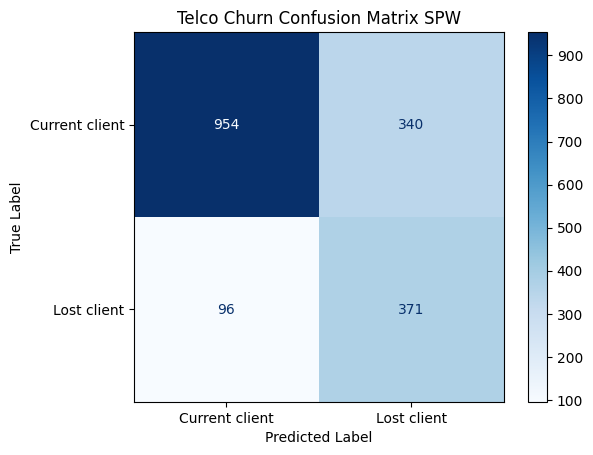

Recall: 0.7944325481798715
Precision: 0.5218002812939522
Specifity: 0.7372488408037094


In [31]:
# Make predictions on the test set
y_pred = churn_clf_SPW.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["Current client", "Lost client"])

# Plot the confusion matrix
cm_disp.plot(cmap='Blues')

# Add title and axis labels
plt.title('Telco Churn Confusion Matrix SPW')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

#print Recall and Precision:
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Specifity:",cm[0, 0]/(cm[0, 0]+cm[0, 1]))


As seen from the confusion matrix, adding the scale_pos_weight parameter alone improved the Recall (prediction of Lost Clients) with ~15%, however this comes at the expence of correctly predicting Current clients.

## 6. Optimise model performance using SMOTE

SMOTE (Synthetic Minority Over-sampling Technique): SMOTE is a machine learning technique used to address the class imbalance problem by generating synthetic examples of the minority class to increase its representation and thus reduce the imbalance between classes.

In [32]:
smote = SMOTE(sampling_strategy="all", random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [33]:
print(sum(y_train_resampled)/len(y_train_resampled))

0.5


In [34]:
# Create the Churn XGBoost classifier
churn_clf_SMOTE = xgb.XGBClassifier(objective="binary:logistic", seed=5,
                              early_stopping_rounds=10, eval_metric="aucpr")

# Fit the model as specified
churn_clf_SMOTE.fit(X_train_resampled, y_train_resampled, verbose=True,
              eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.58032
[1]	validation_0-aucpr:0.60157
[2]	validation_0-aucpr:0.61621
[3]	validation_0-aucpr:0.63209
[4]	validation_0-aucpr:0.62989
[5]	validation_0-aucpr:0.63655
[6]	validation_0-aucpr:0.64153
[7]	validation_0-aucpr:0.64106
[8]	validation_0-aucpr:0.64181
[9]	validation_0-aucpr:0.64278
[10]	validation_0-aucpr:0.64295
[11]	validation_0-aucpr:0.64242
[12]	validation_0-aucpr:0.64111
[13]	validation_0-aucpr:0.63987
[14]	validation_0-aucpr:0.63898
[15]	validation_0-aucpr:0.63895
[16]	validation_0-aucpr:0.64125
[17]	validation_0-aucpr:0.64089
[18]	validation_0-aucpr:0.64409
[19]	validation_0-aucpr:0.64424
[20]	validation_0-aucpr:0.64394
[21]	validation_0-aucpr:0.64511
[22]	validation_0-aucpr:0.64518
[23]	validation_0-aucpr:0.64497
[24]	validation_0-aucpr:0.64434
[25]	validation_0-aucpr:0.64493
[26]	validation_0-aucpr:0.64286
[27]	validation_0-aucpr:0.64123
[28]	validation_0-aucpr:0.64206
[29]	validation_0-aucpr:0.64250
[30]	validation_0-aucpr:0.64206
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

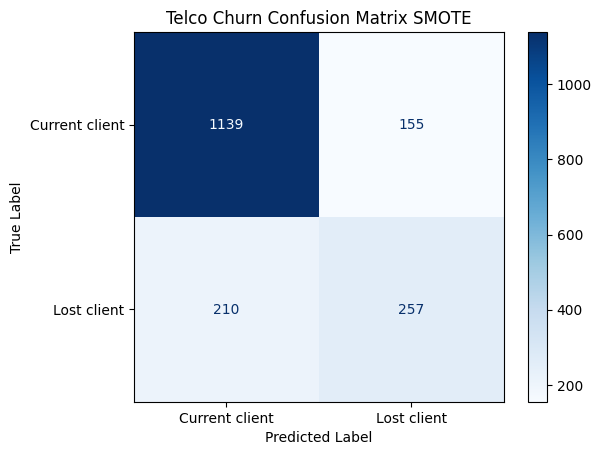

Recall: 0.550321199143469
Precision: 0.6237864077669902
Specifity: 0.8802163833075735


In [35]:
# Make predictions on the test set
y_pred = churn_clf_SMOTE.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["Current client", "Lost client"])

# Plot the confusion matrix
cm_disp.plot(cmap='Blues')

# Add title and axis labels
plt.title('Telco Churn Confusion Matrix SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

#print Recall and Precision:
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Specifity:",cm[0, 0]/(cm[0, 0]+cm[0, 1]))

By using the SMOTE technique alone we do not achieve as high recall as with XGBoost's own parameter.

## 5. Optimise model perofrmance by using cross validation and custom scorer

Additional parameters will be added and fine-tuned:

* subsample and colsample_bytree - to prevent overfitting we will randomise the subset of data used and also subset the number of features used per tree.
* max_depth - maximum depth of the tree
* learning_rate - "eta", determines the step size at each boosting iteration
* gamma - pruning parameter, specifies the minimum loss reduction required to make a further partition on a leaf node
* reg_lambda - applies Ridge regularization on the weights to reduce overfitting

RandomizedSearchCV() will be used for the optimisation.

Since We would like to optimise for both Recall and Specifity, we will use  the make_scorer function to create the metric.


In [36]:
# Create parameters grit to optimise for
param_grid = {
     'scale_pos_weight' :[2.77],
     'max_depth':[3,4,5,7],
     'learning_rate':[0.001,0.01,0.05,0.07,0.1],
     'gamma':[0,0.1,0.2,1,3,5],
     'reg_lambda':[0,0.001, 0.01,0.1,0.5,1],
     'subsample':[0.7,0.8,0.85,0.87,0.9],
     'colsample_bytree':[0.3,0,4,0.5,0.6,0.7,0.8,0.9,0.95,0.98],
     "min_child_weight": [1, 3, 5, 7,10],
     "reg_alpha": [0, 0.001, 0.01]}

In [37]:
# # define a custom recall/specificity/precision scorer
# def specificity_scoring(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     specificity = tn / (tn+fp)
#     return specificity

# def recall_scoring(y_true, y_pred):
#     recall = recall_score(y_true, y_pred)
#     return recall

# def precision_scoring(y_true, y_pred):
#     recall = precision_score(y_true, y_pred)
#     return recall

In [38]:
# # Define the scoring metrics
# scoring_metrics = {
#     'recall': make_scorer(recall_scoring),
#     'specificity': make_scorer(specificity_scoring),
#     'precision':make_scorer(precision_scoring)
# }

In [39]:
# define optimisation problem
optimal_param = RandomizedSearchCV(estimator=churn_clf,
                             param_distributions=param_grid,
                             scoring="f1",
                             verbose=3,
                             n_jobs=100,
                             cv=10)

In [40]:
optimal_param.fit(X_train, y_train, verbose=3,
                  eval_set=[(X_test, y_test)])

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[0]	validation_0-aucpr:0.62899
[3]	validation_0-aucpr:0.63375
[6]	validation_0-aucpr:0.63999
[9]	validation_0-aucpr:0.64894
[12]	validation_0-aucpr:0.64958
[15]	validation_0-aucpr:0.64820
[18]	validation_0-aucpr:0.64579
[21]	validation_0-aucpr:0.64929
[22]	validation_0-aucpr:0.64932


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=10,
                                           enable_categorical=False,
                                           eval_metric='aucpr',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_ra...
                   param_distributions={'colsample_bytree': [0.3, 0, 4, 0.5,
                                                             0.6, 0.7, 0.8, 0.9,
                                                             0.95, 0.98],
                                        'gamma': [0, 0.1, 0.2, 1, 3, 5],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.07, 0.1],
                                        'max_depth': [3, 4, 5, 7],
                                        'min_child_weight': [1, 3, 5, 7, 10],
                                        'reg_alpha': [0, 0.001, 0.01],
                                        'reg_lambda': [0, 0.001, 0.01, 0.1, 0.5,
                                                       1],
                                        'scale_pos_weight': [2.77],
                                        'subsample': [0.7, 0.8, 0.85, 0.87,
                                                      0.9]},
                   scoring='f1', verbose=3)

In [41]:
print(optimal_param.best_params_)

{'subsample': 0.7, 'scale_pos_weight': 2.77, 'reg_lambda': 1, 'reg_alpha': 0, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.07, 'gamma': 0.1, 'colsample_bytree': 0.7}


The best parameters from the optimisation are:

{'subsample': 0.85, 'scale_pos_weight': 2.77, 'reg_lambda': 0.01, 'reg_alpha': 0, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 3, 'colsample_bytree': 0.98}


In [42]:
churn_clf_better=xgb.XGBClassifier(objective="binary:logistic",
                             seed=5,
                              early_stopping_rounds=10,
                              learning_rate=0.01,
                              max_depth=5,
                              subsample=0.85,
                              colsample_bytree=0.98,
                            gamma=3,
                            reg_lambda=0.01,
                            scale_pos_weight=2.77,
                                   min_child_weight=10,
                                   reg_alpha=0
                                   , eval_metric="aucpr"
                                   )


# Fit the model as specified
churn_clf_better.fit(X_train,
                     y_train,
                     verbose=3,
                     eval_set=[(X_test, y_test)]
)


[0]	validation_0-aucpr:0.62780
[3]	validation_0-aucpr:0.64077
[6]	validation_0-aucpr:0.64268
[9]	validation_0-aucpr:0.64071
[12]	validation_0-aucpr:0.63999
[15]	validation_0-aucpr:0.64066
[16]	validation_0-aucpr:0.64038


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.98, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

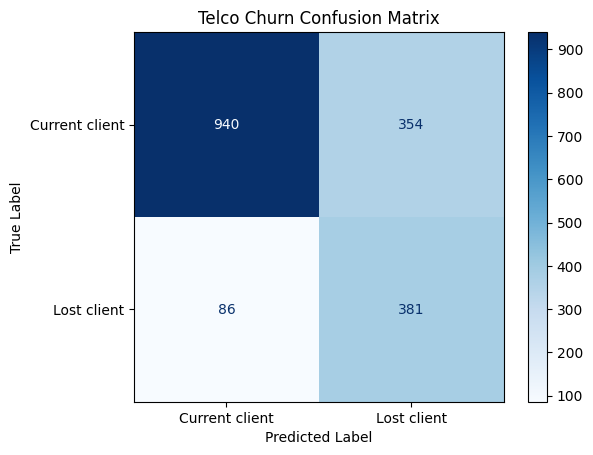

Recall: 0.815845824411135
Precision: 0.5183673469387755
Specifity: 0.7264296754250387


In [43]:
# Make predictions on the test set
y_pred = churn_clf_better.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["Current client", "Lost client"])

# Plot the confusion matrix
cm_disp.plot(cmap='Blues')

# Add title and axis labels
plt.title('Telco Churn Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

#print Recall and Precision:
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("Specifity:",cm[0, 0]/(cm[0, 0]+cm[0, 1]))

With parameter tuning we achieve slightly better results to the previous optimal result - using scale_post_weight parameter only.

## Measure feature importance for the "cross validation and custom scorer" model

### Gain: Measures the average gain (improvement in accuracy or reduction in impurity) each feature brings when used in splits. It highlights features that have the most impact on model accuracy.

In [44]:
# Get feature importance scores - GAIN
importance_df_gain = pd.DataFrame(
    list(churn_clf_better.get_booster().get_score(importance_type='gain').items()),
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

# Display the table
print(importance_df_gain)


                                    Feature   Importance
12                  Contract_Month-to-month  1247.338867
7               InternetService_Fiber_optic   213.797623
0                                    tenure    46.383366
6                       InternetService_DSL    32.572262
8                        InternetService_No    25.992966
1                            MonthlyCharges    25.351358
2                              TotalCharges    22.964756
13                        Contract_One_year    21.242970
14                        Contract_Two_year    17.386177
17           PaymentMethod_Electronic_check    15.327720
15                      PaperlessBilling_No    14.850731
5                             Dependents_No    11.018112
11                           TechSupport_No     9.919816
3                           SeniorCitizen_1     9.665660
4                                Partner_No     9.453078
16  PaymentMethod_Bank_transfer_(automatic)     8.298496
9                         Onlin

### Frequency: Counts the number of times a feature is used in all splits. Frequently used features are usually important but may not be as impactful as those with high gain.

In [45]:
# Get feature importance scores - WEIGHT
importance_df_weight = pd.DataFrame(
    list(churn_clf_better.get_booster().get_score(importance_type='weight').items()),
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

# Display the table
print(importance_df_weight)

                                    Feature  Importance
1                            MonthlyCharges       118.0
0                                    tenure        99.0
2                              TotalCharges        54.0
17           PaymentMethod_Electronic_check        39.0
13                        Contract_One_year        30.0
7               InternetService_Fiber_optic        22.0
12                  Contract_Month-to-month        17.0
15                      PaperlessBilling_No        14.0
9                         OnlineSecurity_No        13.0
6                       InternetService_DSL         7.0
3                           SeniorCitizen_1         6.0
11                           TechSupport_No         4.0
16  PaymentMethod_Bank_transfer_(automatic)         4.0
10                       OnlineSecurity_Yes         3.0
14                        Contract_Two_year         2.0
8                        InternetService_No         1.0
5                             Dependents_No     

### Cover: Reflects the average coverage of observations affected by each feature split. Features with high coverage are used to split a large portion of the data.

In [46]:
# Get feature importance scores - COVER
importance_df_cover = pd.DataFrame(
    list(churn_clf_better.get_booster().get_score(importance_type='cover').items()),
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

# Display the table
print(importance_df_cover)

                                    Feature   Importance
12                  Contract_Month-to-month  1646.142822
7               InternetService_Fiber_optic   943.033752
0                                    tenure   293.901764
13                        Contract_One_year   253.268784
6                       InternetService_DSL   232.549805
14                        Contract_Two_year   221.831970
1                            MonthlyCharges   201.472290
17           PaymentMethod_Electronic_check   196.952621
2                              TotalCharges   170.756912
8                        InternetService_No   165.888702
15                      PaperlessBilling_No   164.334625
3                           SeniorCitizen_1   163.552231
11                           TechSupport_No   113.949951
18               PaymentMethod_Mailed_check   101.139969
4                                Partner_No    90.562920
5                             Dependents_No    47.488583
9                         Onlin